## Machine Learning and Statistics Project 2020
***


The aim of this project is to create a web service that uses machine learning to make predictions based on the data set 'powerproduction'. The goal is to produce a model that accurately predicts wind turbine power output from wind speed values, as in the data set. Then, to develop a web service that will respond with predicted power values based on speed values sent as HTTP requests.

<br>



<br>

## Introduction

***

There are a number of steps involved in creating an accurate predictive model as described in the project brief. This project follows these steps, providing explanations for the choice of model used through analysis of the *powerproduction* data set. With this in mind, it is divided into the following sections:

* Preliminary Analysis
* Function Approximation (Regression vs Classification)
* Regression with `scikit-learn`
* Regression with `keras`
* Model evaluation

<br>



## 1. Preliminary Analysis

***

First, I import the modules needed and choose a style for visualisation throughout the project:

* `numpy` is a python library which allows us to work with arrays, more suited to data analysis than traditional python `lists` [1] 
* `pandas` is suited to working with data sets and provides the DataFrame structure to make this more effective and efficient [2]. 
* `matplotlib.pyplot` is used for visualisation. It is a graph plotting library on which many visualisation packages are built in python. The `pyplot` submodule contains most of matplotlib's utilities [3]
* With the `scikit-learn` library, we have access to numerous machine learning algorithms [4]. In this project it is used to generate predictive models and also to evaluate those models. 
* `tensorflow` is a machine learning platform with a focus on working with and training neural networks [5]. `keras` is an API built on tensorflow, providing an interface for working with neural networks [6].

In [1]:
# Working with arrays
import numpy as np

# Working with dataframes
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Linear regression algorithm
from sklearn.linear_model import LinearRegression

# Working with more complex variable relationships
from sklearn.preprocessing import PolynomialFeatures

# Metrics for evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Splitting data into train and test sets
from sklearn.model_selection import train_test_split

# Working with neural networks
import tensorflow.keras as kr

In [2]:
# Plot style
plt.style.use('ggplot')

# Plot size
plt.rcParams['figure.figsize'] = [11, 6]

Next, I read in the dataset using `pandas.read_csv` which stores the data in a pandas dataframe. I assign this to `pp` and output the first 10 rows. With `pandas.describe` we get a statistical summary of the data set:

In [3]:
# Read in data set
pp = pd.read_csv('powerproduction.csv')

# Output first 10 rows
pp.head(10)

,speed,power
0,0.000,0.000
1,0.125,0.000
2,0.150,0.000
3,0.225,0.000
4,0.275,0.000
5,0.325,4.331
6,0.400,5.186
7,0.450,3.826
8,0.501,1.048
9,0.526,5.553


In [4]:
# Output summary statistics of data set
pp.describe()

,speed,power
count,500.000000,500.000000
mean,12.590398,48.014584
std,7.224991,41.614572
min,0.000000,0.000000
25%,6.324750,5.288000
50%,12.550500,41.645500
75%,18.775250,93.537000
max,25.000000,113.556000


The data set contains two continuous variables. To get an overview of the relationship between them, we can plot them using a scatterplot. Visualising this relationship is a useful first step in understanding what predictive model might be suitable. It can also offer other insights, such as the presence of outliers: 

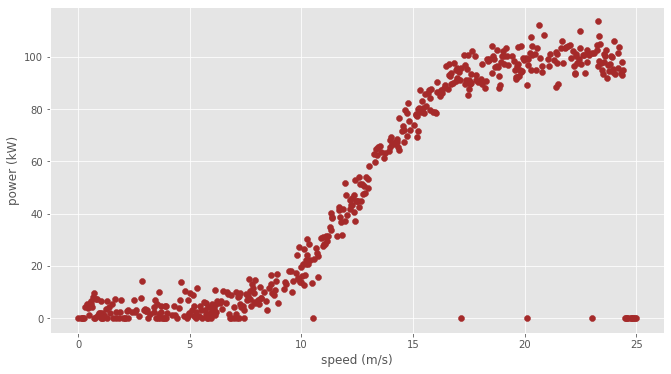

In [5]:
# Plot data on a scatter plot
plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.scatter(pp['speed'], pp['power'], color='brown', marker='o')

#### Wind Turbine Power Curve
This plot produces a visualisation of the typical wind turbine power curve. The *cut-in* wind speed is at ~7m/s, below which the turbine is producing hardly any power. Between wind speeds of ~7 and ~17m/s the power ramps up to what is known as the *rated power capacity*. From approximate speeds of ~17m/s the power generated remains constant, right up to ~25m/s, or the *cut-out* wind speed. While there is much potential power in the wind speed above the cut-out speed, the cost of making the turbine capable of producing power under these conditions outweights the benefits of more power being generated [7]. <br>

#### Outliers
What is also notable from the plot is the presence of seeming outliers in the data. There are a number of observations where no power (0kW) is being generated despite sufficiently high wind speeds. This is something which will be examined in greater detail below.

#### What Predictive Model?
Through visualisation we can get a preliminary indication of what model might best be suited when predicting power output from wind speed. Initial inclinations would suggest that this is a *regression* problem. Given that there are only two variables in the data set, simple linear regression may be an appropriate model although fitting a straight line to the data may not yield the most accurate predictions. It might be more suitable to fit a curve. The variables are clearly *positively* correlated between the *cut-in* speed and the *rated power capacity*. 

##### end section 1

<br>



## 2. Function Approximation: Classification vs Regression

***

*Function approximation* is the term used to describe the problem of approximating a mapping function from input variables to output variables. Generally speaking, function approximation problems can be divided into *classification* and *regression* tasks [8]. Deciding between which of these is most appropriate for the current project is the next step.

#### Classification vs Regression
"Classification predictive modeling is the task of approximating a mapping function (f) from input variables (X) to *discrete* output variables (y)" [9], while the output variables for regression models are *continuous* numeric variables. The aim of the current project is to predict power output from wind speed. As noted above, this is a continuous numeric variable which tells us that regression is an appropriate model/function for this task.

#### Regression
Regression is a statistical method which describes the relationship between a dependent variable and one or more independent variables [10]. Additionally, it is associated with fitting a line (or curve) to the data by plotting the line over the data points to get the best fit [11]. Taking a look data as plotted on a scatter plot, it is clear that we could fit a line (or curve) in order to accurately predict the dependent variable.



##### end section 2

<br>



## 3. Regression with `scikit-learn`

***

`scikit-learn` is a machine learning library for the python programming language. It provides a range of machine learning algorithms and is used widely for the purposes of predictive modelling [12]. In the current project, `scikit-learn`'s `LinearRegression` model will be applied to the *powerproduction* data set. Additionally, the package provides a number of tools which will be used to prepare the data and evaluate the models created below.

### 3.1 Data preparation

***

Before building the first model, it is necessary to prepare the data to maximise the ultimate accuracy of the predictions. Firstly, I use a function to dectect any outliers which may impact the performance of the models. Second, I split the data set into subsets using the *train-test split* procedure.


#### 3.1.1 Outliers

Before applying the linear regression model to the data set, it is important to remove any outliers so that the data we train and test the model on most accurately represents the situation at hand. The removal of outliers must be handled sensitively and cautiously so as not to misrepresent the data, and because every data set is different, there is often a lack of clearly defined rules around how to deal with them [13]. As we saw above, visualisation can give us a strong indication that some of the observations may need to be removed. However, statistical methods can also be used to detect extreme or unlikely values in a data set. 

##### Mahalonibis Distance

In researching outlier detection, much of the online resources appeared to deal with *univariate* outliers [14], [15]. Additionally, detection tools available as part of the `scikit-learn` library e.g. `LocalOutlierFactor`, (which uses the nearest neighbours algorithm to detect outliers in a sample) were not suited to the current project. For *multivariate* outliers, a common statistical method of dection is the *Mahalonibis Distance* measure, which is "... widely used distance metric for the detection of multivariate outliers..." [16]. Indeed it has been applied to wind turbine curve modeling by a number of studies (e.g. Pei and Li, 2019) [17]. 

The code for the function below was found on an informative blog post [18] and applies Mahalonibis Distance to the data set to detect outliers. This function returns a list of index values for the rows containing outliers as detected by the method. I locate these rows using the `pandas.loc` method and remove them from the data set:

In [6]:
import scipy as sp
from scipy.stats import chi2
from sklearn.covariance import MinCovDet

# Set variable df to equal pp data set
df = pp

#Robust Mahalonibis Distance
def robust_mahalanobis_method(df):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(df.values.T)
    X = rng.multivariate_normal(mean=np.mean(df, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = df - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

outliers_mahal_rob, md_rb = robust_mahalanobis_method(df=df)

In [7]:
# Find rows containing outlier indices
pp_outliers = pp.loc[ outliers_mahal_rob , : ]

# Output dataframe of outliers
pp_outliers

,speed,power
340,17.167,0.0
404,20.095,0.0
456,22.998,0.0
490,24.499,0.0
491,24.525,0.0
492,24.575,0.0
493,24.650,0.0
494,24.750,0.0
495,24.775,0.0
496,24.850,0.0


Above is the data frame containing the outlier observations. All the outliers detected have a power value of 0kW. This is what was observed in the scatterplot. Below, I remove them from the data set, creating an updated data set `pp_clean` in the process:

In [8]:
# Remove outliers from data set
pp_clean = pp.drop(outliers_mahal_rob)

In [9]:
pp_clean.describe()

,speed,power
count,487.000000,487.000000
mean,12.294641,49.296287
std,7.077215,41.409933
min,0.000000,0.000000
25%,6.143500,5.769000
50%,12.337000,44.745000
75%,18.380500,93.733500
max,24.399000,113.556000


<br>




#### 3.1.2 Train-test split

The goal of this project is to accurately predict wind turbine power output from wind speed values. Indeed, it is the aim of any predictive model to maximise the accuracy of model output. In machine learning, *evaluation* and *validation* are key aspects in measuring how accurate a model is in this regard [19]. To ensure that the potential for bias is minimized when evaluating model performance, it is common practice in supervised machine learning to apply the *train-test split* procedure. This involves training a model by splitting the data into subsets. The *train* subset is used to train the model while the *test* subset is held back in order to test the model's accuracy. Given that we already know the output values for the test subset, we can make informed comparisons between the predicted observed values. (It is worth pointing out that it may not always be appropriate as a technique to increase accuracy of prediction e.g. if the data set is too small [20].) 



<br>

First, the `pp_clean` data set is split by column into two separate subsets, one containing each variable. :

In [10]:
# Create a new dataset containing only values from the speed column
speed_df = pp_clean.drop('power',axis='columns')

#  Print first 10 rows
speed_df.head(10)

,speed
0,0.000
1,0.125
2,0.150
3,0.225
4,0.275
5,0.325
6,0.400
7,0.450
8,0.501
9,0.526


In [11]:
# Create a new dataset containing only values from the power column
power_df = pp_clean.drop('speed',axis='columns')

# Print first 10 rows
power_df.head(10)

,power
0,0.000
1,0.000
2,0.000
3,0.000
4,0.000
5,4.331
6,5.186
7,3.826
8,1.048
9,5.553


<br>

Next, I pass the speed_df and power_df dataframe subsets to `scikit-learn`'s `train_test_split` method and set the parameter *test_size* to 0.5. The test size indicates the size of the train and test sets. Common split percentages include

* Train: 80%, Test: 20%
* Train: 67%, Test: 33%
* Train: 50%, Test: 50% [21]

The values for the train and test subsets are randomly selected, so I set *random_state* to 1. This reproduces the same division of the data each time the program is run. Setting the seed also allows for more representative model comparison as well as parameter comparison when assessing the performance of different models and functions.

In [12]:
# Call train_test_split method on dataframes
A_Train, A_Test, B_Train, B_Test = train_test_split(speed_df, power_df, test_size = 0.5, random_state=1)


<br>

### 3.2 Simple linear regression

***

Simple linear regression is "... the simplest case of linear regression with a single independent variable" [22]. Its equation is often expressed as <br> $$ y = \Theta_0 + \Theta_1x $$ <br> The *powerproduction* data set contains one independent variable (speed) and one dependent variable (power).  function imported from Python's Scikit-learn library to produce a model. Simple linear regression can be applied when the data set contains only two variables - a dependent and independent variable. This is a condition which is filled by the 'powerproduction' data set.


#### 3.2.1 Fitting the model

I then create an instance of the `LinearRegression()` class and call the `fit` method, passing the training data as arguments. This will create a simple linear regression model:

In [13]:
# Create an instance of the LinearRegression class
reg = LinearRegression()

# Fit our data to the model
#reg.fit(speed_df, power_df)
reg.fit(A_Train, B_Train)

LinearRegression()

#### Check performance

With the training data now fit to the model, the next step is to use the `score` method to see how well the it is performing. This method calculates the the R-squared value (or coefficient of determination [23]). The R-squared value is a 'goodness-of-fit' measure which can give us an indication as to the accuracy of our regression model. The best possible score is 1.0, while a score of 0 or a negative value generally represents a worse-fitting line. The R-squared value "indicates the percentage of the variance in the dependent variable that the independent variables explain collectively." [24] It is worth noting that a high R-squared does not necessarily always indicate the best fit [25].


In [14]:
# Calculate R-squared value
score = reg.score(A_Train, B_Train)

# Print value
print(score)

0.9033195523632082


#### Prediction

Finally, I call the `predict` method on the test data for wind output prediction before plotting this to visualise how well the line fits the data:

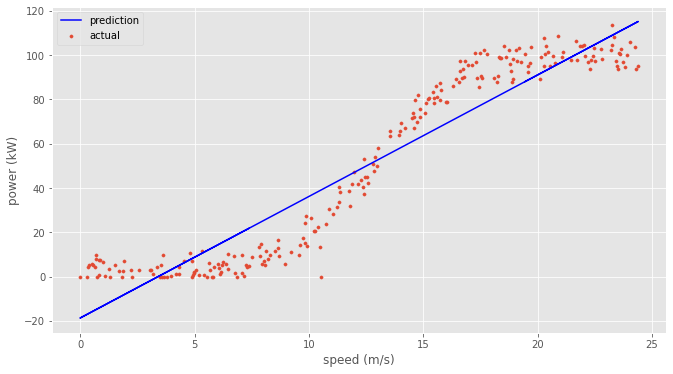

In [71]:
# Use model to make predictions
prediction = reg.predict(A_Test)

# Plot fitted line against data for visualisation
plt.scatter(A_Test, B_Test, label='actual', s=10)
plt.plot(A_Test, prediction, label='prediction', color='b')

plt.xlabel('speed (m/s)')
plt.ylabel('power (kW)')
plt.legend()

We can see clearly that a straight line does not fit the data perfectly. For certain predictive models, an R-squared value of ~0.90 might be considered a satisfactory score. However for the current project, it makes sense to attempt to fit a curve to the data to maximise accuracy of predicted output. The following section applies polynomial regression to the data.

#### Outlier vs no outlier
Before moving to the next section, let us briefly create a model with the original data set (prior to outlier removal) in order to demonstrate the impact of dropping outliers from the data set:

In [16]:
# Using original (pp) data set to train model 
speed_df_pp = pp.drop('power',axis='columns')
power_df_pp = pp.drop('speed',axis='columns')

# Train test split
A_Train_pp, A_Test_pp, B_Train_pp, B_Test_pp = train_test_split(speed_df_pp, power_df_pp, test_size = 0.5, random_state=1)

# Create model
reg_pp = LinearRegression()

# Fit model
reg_pp.fit(A_Train_pp, B_Train_pp)

# Calculate R-squared value
score_pp = reg_pp.score(A_Train_pp, B_Train_pp)

# Print score
print(score_pp)

0.7380879260677631


When the model is trained using the original data set, we can see that there is a significant drop in the score. (~0.74 vs ~0.90). This demonstrates the importance of outlier removal, if appropriate.

<br>

### 3.3 Polynomial regression

***

Visualising the plot above, we can see that the straight line does not follow the curve of the data. This is an example of *under-fitting* [26]. In order to overcome this problem, the complexity of the model needs to be increased. With polynomial regression, we can generate a curve that better captures the data. It involves generating a higher order equation by adding powers to convert features into their higher order terms [27]. The equation for polynomial regression is commonly expressed as: $$ y = \Theta_0 + \Theta_1x + \Theta_2x^2 + \Theta_3x^3 + ... + \Theta_nx^n $$ <br>

`scikit-learn` provides the `PolynomialFeatures` class which enables us to transform features to their higher order terms by setting the degree parameter to the desired power. Then, this model can be trained using `LinearRegression` just as above. The code for this is based on an informative towardsdatascience.com blog post [28].

In [99]:
# lin_x = pp_clean.speed[:, np.newaxis]
# lin_y = pp_clean.power[:, np.newaxis]
lin_x = A_Train.to_numpy()
lin_y = B_Train.to_numpy()

In [95]:
lin_x

array([[ 0.   ],
       [ 0.125],
       [ 0.15 ],
       [ 0.225],
       [ 0.275],
       [ 0.325],
       [ 0.4  ],
       [ 0.45 ],
       [ 0.501],
       [ 0.526],
       [ 0.551],
       [ 0.576],
       [ 0.626],
       [ 0.676],
       [ 0.701],
       [ 0.726],
       [ 0.751],
       [ 0.801],
       [ 0.826],
       [ 0.851],
       [ 0.926],
       [ 0.951],
       [ 0.976],
       [ 1.001],
       [ 1.026],
       [ 1.051],
       [ 1.076],
       [ 1.101],
       [ 1.151],
       [ 1.251],
       [ 1.276],
       [ 1.301],
       [ 1.401],
       [ 1.426],
       [ 1.502],
       [ 1.552],
       [ 1.652],
       [ 1.677],
       [ 1.702],
       [ 1.827],
       [ 1.877],
       [ 1.902],
       [ 2.027],
       [ 2.077],
       [ 2.102],
       [ 2.177],
       [ 2.227],
       [ 2.252],
       [ 2.402],
       [ 2.477],
       [ 2.553],
       [ 2.578],
       [ 2.703],
       [ 2.828],
       [ 2.853],
       [ 2.953],
       [ 3.003],
       [ 3.028],
       [ 3.053

In [115]:
np.sort(lin_x)

array([[21.421],
       [17.593],
       [ 2.027],
       [ 7.883],
       [22.823],
       [13.739],
       [15.14 ],
       [14.039],
       [24.049],
       [16.191],
       [ 8.759],
       [19.945],
       [17.492],
       [11.687],
       [13.964],
       [11.662],
       [ 5.28 ],
       [20.646],
       [ 2.828],
       [11.612],
       [23.023],
       [24.374],
       [ 7.683],
       [12.588],
       [ 7.833],
       [ 2.102],
       [ 5.906],
       [21.446],
       [10.711],
       [ 5.706],
       [ 8.408],
       [ 3.979],
       [23.298],
       [ 4.53 ],
       [ 0.501],
       [ 1.401],
       [ 5.255],
       [21.396],
       [19.895],
       [11.286],
       [ 1.151],
       [18.043],
       [ 2.953],
       [23.373],
       [18.994],
       [23.849],
       [ 2.402],
       [19.97 ],
       [17.367],
       [ 1.426],
       [ 1.552],
       [ 3.403],
       [15.816],
       [11.937],
       [23.949],
       [ 2.177],
       [ 8.859],
       [11.111],
       [21.321

In [107]:
polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(lin_x)
# x_poly = polynomial_features.fit_transform(A_Train)


In [122]:
lin_model = LinearRegression()
lin_model.fit(x_poly, lin_y)
y_poly_pred = lin_model.predict(x_poly)

In [123]:

rmse = np.sqrt(mean_squared_error(lin_y,y_poly_pred))
r2 = r2_score(lin_y,y_poly_pred)
print(rmse)
print(r2)

4.269326527289383
0.9890519709522048


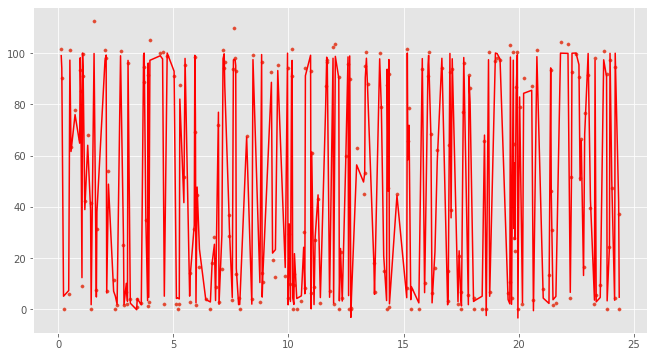

In [124]:
plt.scatter(lin_x, lin_y, s=10)
# sort the values of x before line plot
# sort_axis = operator.itemgetter(0)
# sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
# x, y_poly_pred = zip(*sorted_zip)
plt.plot(lin_x, y_poly_pred, color='r')
plt.show()

Once this is done, we can now test the model for accuracy. We can do this by calling a number of methods provided by the functionality of the `LinearRegresssion()` class.

<br>

First, I take a pick a value for speed and pass it to the `.predict` method

In [17]:
# Predict method using a value for speed
email = 10.89
arr = reg.predict([[9.746]])

<br>

Next, I call the `intercept_` method to determine where the line intercepts the y-axis. And below that I use call `coef_` to get the slope of the line. This gives us all the values for formula for the best-fitting line: $$y = mx + b$$ where m is the slope, b is the y-interept and x is the independent variable [3].

[3] dummies.com; How to calculate a regression line; https://www.dummies.com/education/math/statistics/how-to-calculate-a-regression-line/ <br>

In [18]:
# Call the intercept_ method to determine where the line intercepts the y-axis
reg.intercept_

array([-18.67136645])

In [19]:
# Call the coef_ method to calculate the slope of the line
reg.coef_

array([[5.48508889]])

In [20]:
# Set calculated values
m = 4.91759567
x = 9.746
b = -13.899902630519641

y = m*x + b
print(y)

34.02698476930036


As expected, we get the same result for y when we input these values into the formula (above)
<br>



In [21]:
# Calculate R-squared value
reg.score(speed_df, power_df)

0.9006649798244997

<br>


***

In [22]:
# pp = pp[pp.power != 0]


In [51]:
x = pp['speed']
y = pp['power']

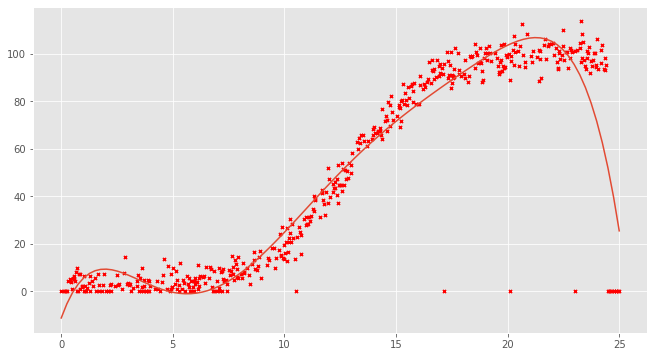

In [52]:
mymodel = np.poly1d(np.polyfit(x, y, 6))

myline = np.linspace(0, 25, 100)

plt.scatter(x, y, color='red', marker='x', s=10)
plt.plot(myline, mymodel(myline))
plt.show()


## Neural network - Regression

***

In [25]:
#pp = pp[pp.power != 0]
#pp.describe()

In [42]:
# Create neural network with one neuron
def create_model():
    model = kr.models.Sequential()
    model.add(kr.Input(shape=(1,)))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(100, activation='relu', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.add(kr.layers.Dense(1, activation='linear', kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
    model.compile(kr.optimizers.Adam(lr=0.001), loss='mean_squared_error')
    
    return model

In [43]:
model = create_model()

In [44]:


msk = np.random.rand(len(pp)) < 0.5
train = pp[msk]

test = pp[~msk]

In [45]:
model.fit(train['speed'], train['power'], epochs=500, batch_size=10)

Epoch 1/500
26/26 [==============================] - 0s 1ms/step - loss: 4052.2555
Epoch 2/500
26/26 [==============================] - 0s 1ms/step - loss: 2314.4904
Epoch 3/500
26/26 [==============================] - 0s 1ms/step - loss: 994.1677
Epoch 4/500
26/26 [==============================] - 0s 1ms/step - loss: 494.4976
Epoch 5/500
26/26 [==============================] - 0s 2ms/step - loss: 371.1942
Epoch 6/500
26/26 [==============================] - 0s 2ms/step - loss: 354.5073
Epoch 7/500
26/26 [==============================] - 0s 1ms/step - loss: 336.1031
Epoch 8/500
26/26 [==============================] - 0s 2ms/step - loss: 334.3947
Epoch 9/500
26/26 [==============================] - 0s 1ms/step - loss: 441.7588
Epoch 10/500
26/26 [==============================] - 0s 1ms/step - loss: 349.6246
Epoch 11/500
26/26 [==============================] - 0s 1ms/step - loss: 356.9409
Epoch 12/500
26/26 [==============================] - 0s 2ms/step - loss: 361.0042
Epoch 13/50

26/26 [==============================] - 0s 906us/step - loss: 370.3428
Epoch 100/500
26/26 [==============================] - 0s 1ms/step - loss: 265.3786
Epoch 101/500
26/26 [==============================] - 0s 1ms/step - loss: 321.9721
Epoch 102/500
26/26 [==============================] - 0s 2ms/step - loss: 393.5659
Epoch 103/500
26/26 [==============================] - 0s 1ms/step - loss: 162.7899
Epoch 104/500
26/26 [==============================] - 0s 2ms/step - loss: 232.8140
Epoch 105/500
26/26 [==============================] - 0s 1ms/step - loss: 141.5671
Epoch 106/500
26/26 [==============================] - 0s 1ms/step - loss: 262.4276
Epoch 107/500
26/26 [==============================] - 0s 2ms/step - loss: 277.2899
Epoch 108/500
26/26 [==============================] - 0s 1ms/step - loss: 325.4579
Epoch 109/500
26/26 [==============================] - 0s 2ms/step - loss: 187.1993
Epoch 110/500
26/26 [==============================] - 0s 2ms/step - loss: 293.8384
Epoc

26/26 [==============================] - 0s 2ms/step - loss: 283.3720
Epoch 197/500
26/26 [==============================] - 0s 2ms/step - loss: 187.7149
Epoch 198/500
26/26 [==============================] - 0s 1ms/step - loss: 75.5866
Epoch 199/500
26/26 [==============================] - 0s 2ms/step - loss: 277.4280
Epoch 200/500
26/26 [==============================] - 0s 1ms/step - loss: 143.9636
Epoch 201/500
26/26 [==============================] - 0s 1ms/step - loss: 174.0148
Epoch 202/500
26/26 [==============================] - 0s 1ms/step - loss: 130.4198
Epoch 203/500
26/26 [==============================] - 0s 1ms/step - loss: 250.5743
Epoch 204/500
26/26 [==============================] - 0s 1ms/step - loss: 244.4921
Epoch 205/500
26/26 [==============================] - 0s 1ms/step - loss: 219.1159
Epoch 206/500
26/26 [==============================] - 0s 2ms/step - loss: 184.6259
Epoch 207/500
26/26 [==============================] - 0s 2ms/step - loss: 279.5908
Epoch 2

26/26 [==============================] - 0s 1ms/step - loss: 270.4787
Epoch 294/500
26/26 [==============================] - 0s 1ms/step - loss: 346.6479
Epoch 295/500
26/26 [==============================] - 0s 886us/step - loss: 144.4695
Epoch 296/500
26/26 [==============================] - 0s 1ms/step - loss: 130.7132
Epoch 297/500
26/26 [==============================] - 0s 2ms/step - loss: 93.4834
Epoch 298/500
26/26 [==============================] - 0s 1ms/step - loss: 148.8944
Epoch 299/500
26/26 [==============================] - 0s 1ms/step - loss: 148.1360
Epoch 300/500
26/26 [==============================] - 0s 2ms/step - loss: 119.0499
Epoch 301/500
26/26 [==============================] - 0s 2ms/step - loss: 85.0803
Epoch 302/500
26/26 [==============================] - 0s 2ms/step - loss: 189.9610
Epoch 303/500
26/26 [==============================] - 0s 1ms/step - loss: 273.2189
Epoch 304/500
26/26 [==============================] - 0s 1ms/step - loss: 100.7096
Epoch 

26/26 [==============================] - 0s 1ms/step - loss: 178.6356
Epoch 391/500
26/26 [==============================] - 0s 1ms/step - loss: 166.5310
Epoch 392/500
26/26 [==============================] - 0s 1ms/step - loss: 154.3036
Epoch 393/500
26/26 [==============================] - 0s 1ms/step - loss: 185.6382
Epoch 394/500
26/26 [==============================] - 0s 2ms/step - loss: 102.6485
Epoch 395/500
26/26 [==============================] - 0s 1ms/step - loss: 209.7783
Epoch 396/500
26/26 [==============================] - 0s 2ms/step - loss: 114.7089
Epoch 397/500
26/26 [==============================] - 0s 1ms/step - loss: 162.8397
Epoch 398/500
26/26 [==============================] - 0s 1ms/step - loss: 78.7765
Epoch 399/500
26/26 [==============================] - 0s 1ms/step - loss: 182.9381
Epoch 400/500
26/26 [==============================] - 0s 1ms/step - loss: 137.1747
Epoch 401/500
26/26 [==============================] - 0s 2ms/step - loss: 105.7701
Epoch 4

26/26 [==============================] - 0s 886us/step - loss: 114.9397
Epoch 488/500
26/26 [==============================] - 0s 1ms/step - loss: 146.4999
Epoch 489/500
26/26 [==============================] - 0s 1ms/step - loss: 189.0712
Epoch 490/500
26/26 [==============================] - 0s 1ms/step - loss: 229.3077
Epoch 491/500
26/26 [==============================] - 0s 1ms/step - loss: 165.7199
Epoch 492/500
26/26 [==============================] - 0s 2ms/step - loss: 106.6060
Epoch 493/500
26/26 [==============================] - 0s 1ms/step - loss: 361.8631
Epoch 494/500
26/26 [==============================] - 0s 1ms/step - loss: 110.7784
Epoch 495/500
26/26 [==============================] - 0s 2ms/step - loss: 111.4539
Epoch 496/500
26/26 [==============================] - 0s 2ms/step - loss: 179.5878
Epoch 497/500
26/26 [==============================] - 0s 1ms/step - loss: 141.3093
Epoch 498/500
26/26 [==============================] - 0s 2ms/step - loss: 213.1266
Epoc

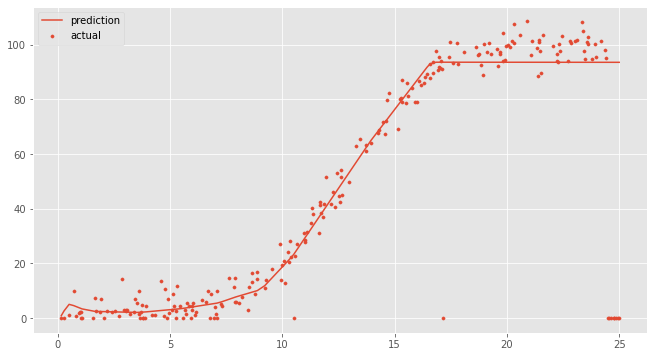

In [46]:
plt.scatter(test['speed'], test['power'], label='actual', s=10)
plt.plot(test['speed'], model.predict(test['speed']), label='prediction')
plt.legend()

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               200       
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
_________________________________________________________________


In [48]:
# model.save('my_model.h5')

In [49]:
model.predict([14])

array([[65.558426]], dtype=float32)

13.362188712628802
0.8966920390253903


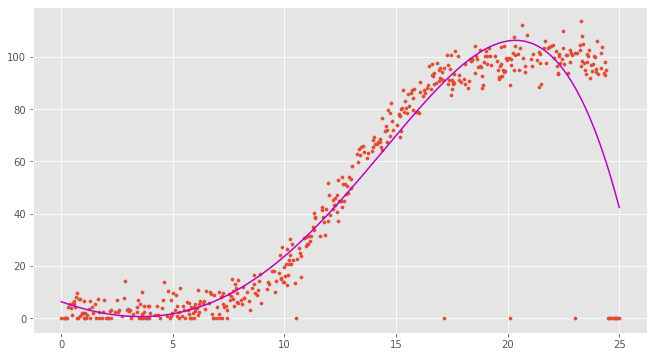

In [39]:
np.random.seed(0)
x = 2 - 3 * np.random.normal(0, 1, 20)
y = x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(-3, 3, 20)

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print(rmse)
print(r2)

10.120437473614711
0.8537647164420812


### References

[1] w3schools.com; Numpy Introduction; https://www.w3schools.com/python/numpy_intro.asp <br>
[2] w3schools.com; Pandas Tutorial https://www.w3schools.com/python/pandas_tutorial.asp <br>
[3] w3schools.com; Matplotlib Pyplot; https://www.w3schools.com/python/matplotlib_pyplot.asp <br>
[4] wikipedia.org; scikit_learn https://en.wikipedia.org/wiki/Scikit-learn <br>
[5] tensorflow.org; https://www.tensorflow.org/ <br>
[6] keras.io; https://keras.io/ <br>
[7] youtube.com; Wind Turbine Power Curve description; https://www.youtube.com/watch?v=8tNOL4ZL9Do <br>
[8] Brownlee, J.; Difference Between Classification and Regression in Machine Learning https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/ <br>
[9] *Ibid* <br>
[10] Wikipedia.org; Regression analysis; https://en.wikipedia.org/wiki/Regression_analysis <br>
[11] yale.edu; Linear Regression; http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm <br>
[12] wikipdeia.org; scikit-learn; https://en.wikipedia.org/wiki/Scikit-learn <br>
[13] realpython.com; Split Your Dataset With scikit-learn's train_test_split(); https://realpython.com/train-test-split-python-data/ <br>
[14] machinelearningmastery.com; Train-Test Split for Evaluating Machine Learning Algorithms; https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/ <br>
[15] *Ibid* <br>
[16] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[17] Pei, S. and Li, P., 2019; Wind Turbine Power Curve Modeling with a Hybrid Machine Learning Technique; https://www.researchgate.net/publication/337325612_Wind_Turbine_Power_Curve_Modeling_with_a_Hybrid_Machine_Learning_Technique <br>
[18] Detecting And Treating Outliers In Python — Part 2; https://towardsdatascience.com/detecting-and-treating-outliers-in-python-part-2-3a3319ec2c33 <br>
[19] Brownlee, J; How to Remove Outliers for Machine Learning; https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/ <br>
[20] *Ibid* <br>
[21] Frost, J; 5 Ways to Find Outliers in Your Data; https://statisticsbyjim.com/basics/outliers/ <br>
[22] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[23] realpython.com; Linear Regression in Python; https://realpython.com/linear-regression-in-python/ <br>
[24] Frost, J; How To Interpret R-squared in Regression Analysis; https://statisticsbyjim.com/regression/interpret-r-squared-regression/ <br>
[25] *Ibid* <br>
[26] Agarwal, A.; Polynomial Regression; https://towardsdatascience.com/polynomial-regression-bbe8b9d97491 <br>
[27] *Ibid* <br>
[28] *Ibid* <br>